In [ ]:
# TRAP MAIN PLOT (paper)

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st

from stoch_mcts.agent.agent import Agent
from stoch_mcts.game.game import Trap
import stoch_mcts.trainer.trainer as train
import stoch_mcts.mcts.mcts as mcts_
from stoch_mcts.mcts.graph import Node
from stoch_mcts.mcts.path import Path
import stoch_mcts.mcts.backpropagator as bkprop
import stoch_mcts.mcts.evaluator as ev
import stoch_mcts.mcts.selector as sel

ar_factor = 0.1
ar_exponent = -0.1

env = Trap()
act_sel: sel.ActionSelector = sel.UCT(c=100)
back_prop = bkprop.TreeBackpropagator(discount=0.1)

# AR agent
state_sel_ar: sel.StateSelector = sel.AbstractionRefining(k=ar_factor,alpha=ar_exponent,dist=env.distance)
selector_ar = sel.Selector(act_sel,state_sel_ar)
evaluator_ar: ev.Evaluator = ev.RandomRollouts(discount=0.1)
mcts_ar = mcts_.MCTS(selector_ar,evaluator_ar,back_prop)
agent_ar = Agent(mcts_ar)

# AR = [142.8, 141.26, 148.23, 157.91, 170.0, 170.0, 170] 

n_trials = 1000
num_rollouts = [10, 20, 50, 100, 200, 500, 1000]
pw_factors = [1/50, 1/20, 1, 2]
pw_exponents = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_e = len(pw_exponents)
ar_index = 0

df = {'method': [], 'return': [], 'num_rollouts': [], 'k': [], 'exp': []}

for e_idx in range(8):
  e = pw_exponents[e_idx]
  df['method'].append(f'PW{e}')
  df['num_rollouts'].append(num_rollouts[0])
  df['exp'].append(e)
  df['k'].append(pw_factors[0])
  df['return'].append(200)

for nr in num_rollouts:
  for k in pw_factors:
    start_idx = 0    
    end_idx = max_e
    step = 1
    if k==pw_factors[0]:
      start_idx = 8
    if k==pw_factors[1]:
      start_idx = 5
      end_idx = 10
    if k==pw_factors[2]:
      start_idx = 1
      end_idx = 8
      step = 2
    if k==pw_factors[3]:
      start_idx = 0
      end_idx = 5
    for e_idx in range(start_idx, end_idx, step):
      e = pw_exponents[e_idx]
      state_sel_pw: sel.StateSelector = sel.ProgressiveWidening(k,alpha=e)
      selector_pw = sel.Selector(act_sel,state_sel_pw)
      evaluator_pw: ev.Evaluator = ev.RandomRollouts(discount=0.1)
      back_prop_pw = bkprop.TreeBackpropagator(discount=0.1)
      mcts_pw = mcts_.MCTS(selector_pw,evaluator_pw,back_prop_pw)
      agent_pw = Agent(mcts_pw)
      PW = train.run(env,agent_pw,num_episodes=n_trials,n_rollouts=nr)
      for pw in PW:
        df['method'].append(f'PW{e}')
        df['num_rollouts'].append(nr)
        df['exp'].append(e)
        df['k'].append(k)
        df['return'].append(pw)
    AR = train.run(env,agent_ar,num_episodes=n_trials,n_rollouts=nr)
    for ar in AR:
      df['method'].append('AR')
      df['num_rollouts'].append(nr)
      df['exp'].append(ar_exponent)
      df['k'].append(k)
      df['return'].append(ar)

df_ = pd.DataFrame(df)
plt.close()
df_.to_pickle('trap_return_df.pkl')
df_['return'] = df_['return'].astype(float)
ax = sns.relplot(data=df_, x='num_rollouts', y='return', hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
ax.set(ylim=(135, 171))
# ax.set(yscale="log")
plt.show()
# plt.savefig('results/trap/return_1000.png')
# plt.savefig('results/trap/return_1000.pdf')
# plt.close()



Plot additional figure (appendix): AR return with different hyperparameters 

In [ ]:
# TRAP ADDITIONAL PAPER PLOT (appendix)

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st

from stoch_mcts.agent.agent import Agent
from stoch_mcts.game.game import Trap
import stoch_mcts.trainer.trainer as train
import stoch_mcts.mcts.mcts as mcts_
from stoch_mcts.mcts.graph import Node
from stoch_mcts.mcts.path import Path
import stoch_mcts.mcts.backpropagator as bkprop
import stoch_mcts.mcts.evaluator as ev
import stoch_mcts.mcts.selector as sel

ar_factor = [0.05, 0.1, 0.5]
ar_exponent = [0.1, 0.5, 1]

env = Trap()
act_sel: sel.ActionSelector = sel.UCT(c=100)
back_prop = bkprop.TreeBackpropagator(discount=0.1)

n_trials = 1000
num_rollouts = [10, 20, 50, 100, 200, 500, 1000]

df = {'method': [], 'return': [], 'num_rollouts': [], 'k': [], 'exp': []}

for nr in num_rollouts:
  for k in ar_factor:
    for e in ar_exponent:
      # AR agent
      state_sel_ar: sel.StateSelector = sel.AbstractionRefining(k=k,alpha=-e,dist=env.distance)
      selector_ar = sel.Selector(act_sel,state_sel_ar)
      evaluator_ar: ev.Evaluator = ev.RandomRollouts(discount=0.1)
      mcts_ar = mcts_.MCTS(selector_ar,evaluator_ar,back_prop)
      agent_ar = Agent(mcts_ar)
      AR = train.run(env,agent_ar,num_episodes=n_trials,n_rollouts=nr)
      for ar in AR:
        df['method'].append(f'AR{e}')
        df['num_rollouts'].append(nr)
        df['exp'].append(e)
        df['k'].append(k)
        df['return'].append(ar)

df_ = pd.DataFrame(df)
plt.close()
df_.to_pickle('trap_ar_df.pkl')
df_['return'] = df_['return'].astype(float)
ax = sns.relplot(data=df_, x='num_rollouts', y='return', hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
ax.set(ylim=(135, 171))
# ax.set(yscale="log")
plt.show()
# plt.savefig('results/trap/return_ar.png')
# plt.savefig('results/trap/return_ar.pdf')
# plt.close()


Plot the dataframe with viridis palette 

/home/riccardo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


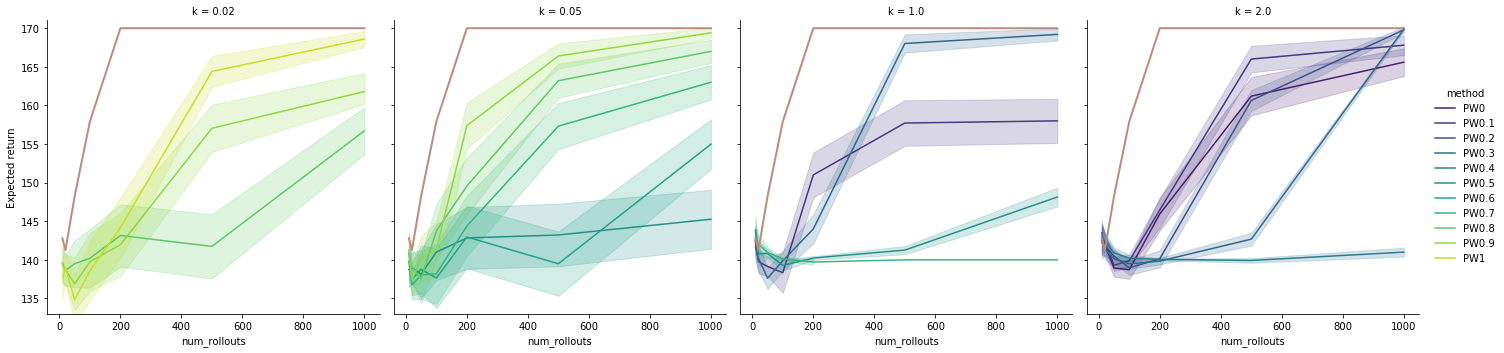

In [9]:
# PLOT the dataframe

import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import pandas as pd

with open('trap_df.pkl', 'rb') as f:
    data = pickle.load(f)

method_list = data['method']
AR_indexes = [x for x in range(len(method_list)) if method_list[x] == 'AR']
AR_rows = data.iloc[AR_indexes]
PW_indexes = [x for x in range(len(method_list)) if method_list[x] != 'AR']
PW_rows = data.iloc[PW_indexes]
k_list = AR_rows['k'].tolist()
indexes_k = [x for x in range(len(k_list)) if k_list[x] == 0.02]
AR_rows_k = AR_rows.iloc[indexes_k]
# AR_values = AR_rows_k['return']
AR_values = [142.8, 141.26, 148.23, 157.91, 170.0, 170.0, 170] # We extracted the mean once and then plot it directly
# print(AR_values)
num_rollouts = [10, 20, 50, 100, 200, 500, 1000]
line1 = lines.Line2D(num_rollouts,
                    AR_values,
                    lw = 2, color =(189/255,140/255,125/255))
line2 = lines.Line2D(num_rollouts,
                    AR_values,
                    lw = 2, color =(189/255,140/255,125/255))
line3 = lines.Line2D(num_rollouts,
                    AR_values,
                    lw = 2, color =(189/255,140/255,125/255))
line4 = lines.Line2D(num_rollouts,
                    AR_values,
                    lw = 2, color =(189/255,140/255,125/255))

g = sns.relplot(data=PW_rows, x='num_rollouts', y='return', hue='method', kind='line', col='k', palette='viridis', facet_kws={'sharey': True, 'sharex': True})
axes = g.axes.flatten()
axes[0].add_line(line1)
axes[1].add_line(line2)
axes[2].add_line(line3)
axes[3].add_line(line4)
g.set(ylim=(133, 171))
# ax.set(yscale="log")
g.set(ylabel="Expected return")
plt.show()